In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

import pandas as pd  # 导入pandas库，用于数据处理和分析
import numpy as np  # 导入numpy库，用于数值计算
import xgboost as xgb  # 导入XGBoost库，用于梯度提升决策树模型
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier  # 导入决策树回归和分类模型
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier  # 导入随机森林、AdaBoost和梯度提升模型
from sklearn import preprocessing #数据预处理：归一化

from sklearn.metrics import mean_absolute_error, r2_score  # 导入评估指标，包括平均绝对误差和R^2分数

import matplotlib.pyplot as plt  # 导入matplotlib库，用于绘图
import warnings  # 导入警告处理库
warnings.filterwarnings('ignore')  # 忽略警告信息
from math import sqrt  # 导入数学库中的平方根函数

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)  # 将输入的实际值和预测值转换为NumPy数组
    tt1 = (actual - pred) / actual  # 计算相对误差
    tt2 = np.isfinite(tt1)  # 检查相对误差中是否有无穷大值
    tt3 = tt1[tt2]  # 去除无穷大值
    return np.mean(np.abs(tt3)) * 100  # 计算平均绝对百分比误差（MAPE）并返回

# 数据导入

In [2]:
df=pd.read_excel('data2.xlsx')
X =df[df.columns[1:8]]
Y =df[df.columns[9]]
print(X)
print(Y)

#归一化
X = (X - X.min()) / (X.max() - X.min())
Y = (Y - Y.min()) / (Y.max() - Y.min())

    人口出生率(‰)    出生人口（万人）  人口死亡率(‰)   死亡人口（万人）  人口自然增长率(‰)    增长人口（万人）  城镇化率(%)
0      38.00  2756.44400      9.50  689.11100       28.50  2067.33300    17.98
1      35.21  2624.62382      8.87  661.18754       26.34  1963.43628    17.86
2      34.12  2605.67616      8.47  646.83696       25.65  1958.83920    17.76
3      35.75  2807.59050      8.25  647.90550       27.50  2159.68500    17.63
4      34.25  2762.98175      8.06  650.20826       26.19  2112.77349    17.86
5      33.59  2787.70128      7.64  634.05888       25.95  2153.64240    17.99
6      30.74  2619.93946      7.34  625.58086       23.40  1994.35860    17.54
7      29.92  2608.33584      7.65  666.90405       22.27  1941.43179    17.55
8      28.07  2504.15277      7.08  631.61388       20.99  1872.53889    17.63
9      24.95  2266.93205      7.38  670.53942       17.57  1596.39263    17.54
10     23.13  2137.67460      7.36  680.21120       15.77  1457.46340    17.88
11     20.01  1875.27717      7.29  683.19693       

# 预训练GBDT模型

In [3]:
# 构建GBDT回归模型
gbdt_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
gbdt_model.fit(X, Y)
gbdt_y_pred = gbdt_model.predict(X)
# 输出GBDT模型评价结果
print('GBDT模型训练误差：')
print("   平均绝对百分比误差:",mape(Y, gbdt_y_pred))
print("   r2_score",r2_score(Y,gbdt_y_pred))


GBDT模型训练误差：
   平均绝对百分比误差: 0.0033941166623282005
   r2_score 0.9999999989954711


# 建模前的准备工作

Results of ADF Test:
Test Statistic                 -1.028023
p-value                         0.742907
#Lags Used                     10.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


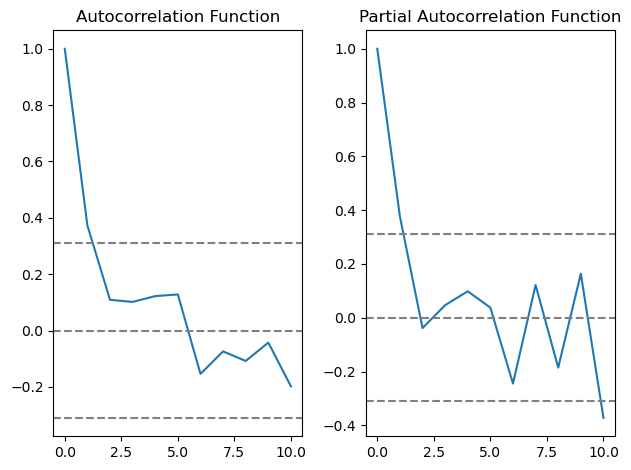

                               SARIMAX Results                                
Dep. Variable:               人口出生率(‰)   No. Observations:                   41
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -62.589
Date:                Sun, 21 Jan 2024   AIC                            131.178
Time:                        22:26:57   BIC                            136.169
Sample:                             0   HQIC                           132.969
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4101      0.199      2.063      0.039       0.020       0.800
ma.L1         -0.9444      0.168     -5.631      0.000      -1.273      -0.616
sigma2         1.3986      0.333      4.196      0.0

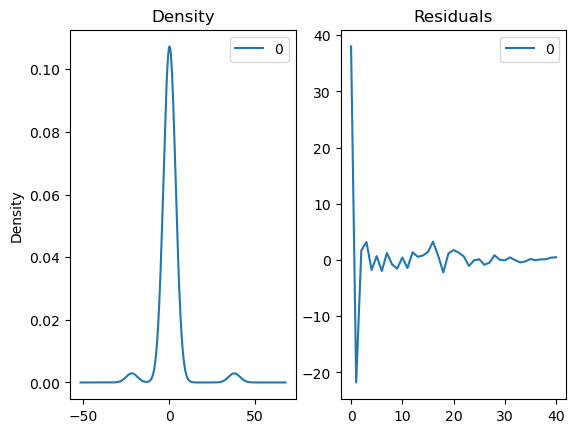

In [4]:
#建模前的准备工作：
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

#人口出生率(‰)
data=df[df.columns[1]]
ts = pd.Series(data)

# ADF 检验
def adf_test(timeseries):
    print('Results of ADF Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# 差分
def difference(timeseries):
    differenced = timeseries.diff().dropna()
    return differenced

# ACF 和 PACF
def plot_acf_pacf(timeseries):
    lag_acf = acf(timeseries, nlags=10)
    lag_pacf = pacf(timeseries, nlags=10, method='ols')

    # 绘制 ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    # 绘制 PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

# 执行ADF检验
adf_test(ts)

# 发现数据不平滑，则进行差分处理
diff_ts = difference(ts)

# 绘制ACF和PACF
plot_acf_pacf(diff_ts)

# 模型拟合定参
model = ARIMA(ts, order=(1, 2, 1))
results = model.fit()
print(results.summary())

# 残差检查
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[1])
residuals.plot( kind='kde',title='Density', ax=ax[0])
plt.show()

Results of ADF Test:
Test Statistic                 -1.440383
p-value                         0.562770
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


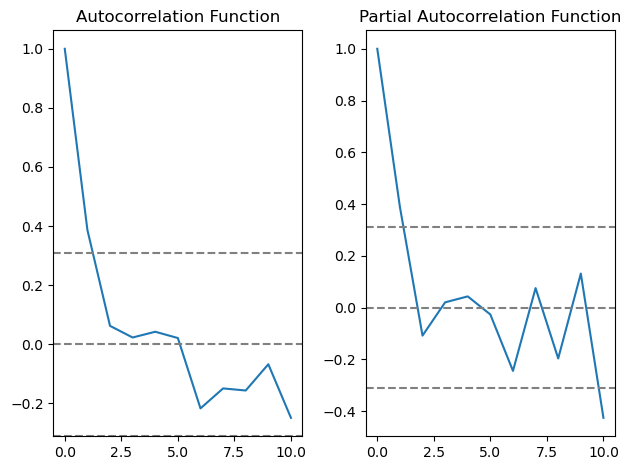

                               SARIMAX Results                                
Dep. Variable:               出生人口（万人）   No. Observations:                   41
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -239.020
Date:                Sun, 21 Jan 2024   AIC                            484.040
Time:                        22:26:57   BIC                            489.031
Sample:                             0   HQIC                           485.831
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4167      0.195      2.132      0.033       0.034       0.800
ma.L1         -0.9987      7.554     -0.132      0.895     -15.804      13.807
sigma2      1.156e+04   8.68e+04      0.133      0.8

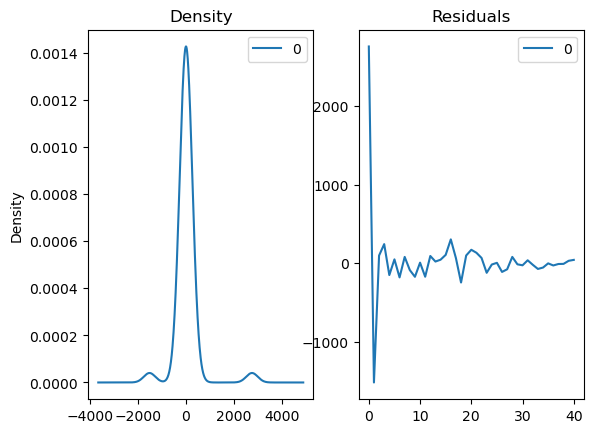

In [5]:
#出生人口（万人）
data=df[df.columns[2]]
ts = pd.Series(data)

# ADF 检验
def adf_test(timeseries):
    print('Results of ADF Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# 差分
def difference(timeseries):
    differenced = timeseries.diff().dropna()
    return differenced

# ACF 和 PACF
def plot_acf_pacf(timeseries):
    lag_acf = acf(timeseries, nlags=10)
    lag_pacf = pacf(timeseries, nlags=10, method='ols')

    # 绘制 ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    # 绘制 PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

# 执行ADF检验
adf_test(ts)

# 发现数据不平滑，则进行差分处理
diff_ts = difference(ts)

# 绘制ACF和PACF
plot_acf_pacf(diff_ts)

# 模型拟合定参
model = ARIMA(ts, order=(1, 2, 1))
results = model.fit()
print(results.summary())

# 残差检查
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[1])
residuals.plot( kind='kde',title='Density', ax=ax[0])
plt.show()

其他数据的预处理操作类似，不再重复提供代码

# 建立组合模型

In [11]:
data = {
    "年份": np.arange(1990, 2006),
    "死亡人口（万人）": [762.60, 776.01, 778.02, 786.95, 777.83, 795.76, 802.87, 804.81, 810.95, 812.58, 817.49, 820.64, 823.38, 827.05, 834.52, 851.22],
    "年末总人口(万人)": [114333, 115823, 117171, 118517, 119850, 121121, 122389, 123626, 124761, 125786, 126743, 127627, 128453, 129227, 129988, 130756],
    "人口自然增长率(‰)":[26.41, 26.53, 27.63, 28.14, 28.62, 29.04, 29.37, 29.97, 30.40, 30.89, 36.22, 37.66, 39.09, 40.53, 41.67, 42.99],
    "出生人口（万人）": [2407.85, 2279.40, 2137.20, 2143.97, 2121.35, 2073.59, 2078.17, 2048.48, 1951.26, 1841.51, 1778.20, 1707.65, 1651.91, 1603.71, 1597.55, 1621.37],
    "城镇化率(%)": [26.41, 26.53, 27.63, 28.14, 28.62, 29.04, 29.37, 29.97, 30.40, 30.89, 36.22, 37.66, 39.09, 40.53, 41.67, 42.99],
    "老龄化率(%)":[6.1, 6.2,6.3, 6.5, 6.6,6.6,7.1, 7.3, 7.5, 7.7, 7.8, 8.0, 8.2, 8.4,8.9, 9.1]
}
df = pd.DataFrame(data)
df.set_index("年份", inplace=True)

# 为每个外生变量建立时间序列模型
# 出生人口模型
model_birth = ARIMA(df["出生人口（万人）"], order=(1, 3, 1))
model_birth_fit = model_birth.fit()
future_births = model_birth_fit.forecast(steps=18)

# 死亡人口模型
model_death = ARIMA(df["死亡人口（万人）"], order=(1, 3, 2))
model_death_fit = model_death.fit()
future_deaths = model_death_fit.forecast(steps=18)

# 城镇化率模型
model_urbanization = ARIMA(df["城镇化率(%)"], order=(1, 2, 1))
model_urbanization_fit = model_urbanization.fit()
future_urbanization = model_urbanization_fit.forecast(steps=18)

#人口增长率
model_gr = ARIMA(df["人口自然增长率(‰)"], order=(1, 3, 2))
model_gr_fit = model_gr.fit()
growth_rate = model_gr_fit.forecast(steps=18)

#老龄化率
model_old = ARIMA(df["老龄化率(%)"], order=(1, 3, 2))
model_old_fit = model_old.fit()
old_rate = model_old_fit.forecast(steps=18)

future_years_corrected = np.arange(2006, 2024)
# 预测年末总人口
future_data = pd.DataFrame({
    "出生人口（万人）": future_births.values,
    "死亡人口（万人）": future_deaths.values,
    "城镇化率(%)": future_urbanization.values
}, index=future_years_corrected)

# 进行总人口预测
gbdt_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)#重新调用GBDT
gbdt_model.fit(X, Y)
gbdt_y_pred = gbdt_model.predict(X)
model = sm.tsa.ARIMA(df["年末总人口(万人)"], order=(2, 2, 2), exog=df[["出生人口（万人）", "死亡人口（万人）", "城镇化率(%)"]])
model_fit = model.fit()
forecast_total_population = model_fit.forecast(steps=18, exog=future_data)

# 输出预测结果
print(forecast_total_population)

16    131527.751976
17    132289.454506
18    133034.553047
19    133760.476130
20    134466.401829
21    135152.351948
22    135818.697747
23    136465.994585
24    137094.840867
25    137705.876650
26    138299.719210
27    138876.997346
28    139438.303624
29    139984.236417
30    140515.355764
31    141032.227062
32    141535.377704
33    142025.341086
Name: predicted_mean, dtype: float64


In [12]:
#模型评估
#2006~2015实际人口
Y_actual1=[131448,132129,132802,133450,134910,134735,135404,136072,136782,137462,]
Y_pre1=[131527.751976,132289.454506,133034.553047,133760.476130,134466.401829,135152.351948,135818.697747,136465.994585,137094.840867,137705.876650]
Y_actual1=np.array(Y_actual1)
Y_pre1=np.array(Y_pre1)

# 计算误差
errors1 = Y_actual1 - Y_pre1
# 计算平均百分比误差（Mean Percentage Error, MPE）
mpe1 = np.mean((errors1 / Y_actual1) * 100)

print("中短期预测平均百分比误差:",mpe1,"%")

中短期预测平均百分比误差: -0.15727673720921162 %


In [13]:
#模型评估
#2006~2023实际人口
Y_actual=[131448,132129,132802,133450,134910,134735,135404,136072,136782,137462,138271,139008,139538,140005,141212,141260,141175,140976,]
Y_pre=np.array(forecast_total_population)

# 计算误差
errors = Y_actual - Y_pre
# 计算平均百分比误差（Mean Percentage Error, MPE）
mpe = np.mean((errors / Y_actual) * 100)

print("长期预测平均百分比误差:",mpe,"%")

长期预测平均百分比误差: -0.09766960732055358 %


In [14]:
#对比试验:单一模型中短期预测
population_data = [
    114333, 115823, 117171, 118517, 119850, 121121, 122389, 123626,
    124761, 125786, 126743, 127627, 128453, 129227, 129988, 130756
]

# 将数据转换为Pandas Series（假设每个数据点代表一个年份）
population_series = pd.Series(population_data, index=pd.date_range(start='1990', periods=len(population_data), freq='A'))

# ARIMA模型拟合
model = ARIMA(population_series, order=(1, 2, 1))
model_fit = model.fit()

# 预测未来17年的人口数量
forecast = model_fit.forecast(steps=10)

forecast_values = forecast.values
forecast_years = list(range(population_series.index[-1].year+1 , population_series.index[-1].year+11 ))
forecast_series2 = pd.Series(forecast_values, index=forecast_years)

print(forecast_series2)

2006    131524.725758
2007    132293.672665
2008    133062.686960
2009    133831.721788
2010    134600.762873
2011    135369.805865
2012    136138.849438
2013    136907.893188
2014    137676.936992
2015    138445.980813
dtype: float64


In [15]:
#对照组误差分析
# 真实人口数据
real_population = np.array([
    131448, 132129, 132802, 133450, 134091, 134735, 135404,136072, 136782, 137462, 
])

# 预测人口数据
predicted_population = forecast.values

# 计算平均百分比误差 (Mean Percentage Error, MPE)
errors = real_population - predicted_population
percentage_errors = errors / real_population
mean_percentage_error = np.mean(percentage_errors) * 100

print("中短期预测平均百分比误差：",mean_percentage_error,"%")

中短期预测平均百分比误差： -0.40437626810177363 %


In [16]:
#对比试验:单一模型长期预测
population_data = [
    114333, 115823, 117171, 118517, 119850, 121121, 122389, 123626,
    124761, 125786, 126743, 127627, 128453, 129227, 129988, 130756
]

# 将数据转换为Pandas Series（假设每个数据点代表一个年份）
population_series = pd.Series(population_data, index=pd.date_range(start='1990', periods=len(population_data), freq='A'))

# ARIMA模型拟合
model = ARIMA(population_series, order=(1, 2, 1))
model_fit = model.fit()

# 预测未来18年的人口数量
forecast = model_fit.forecast(steps=18)

forecast_values = forecast.values
forecast_years = list(range(population_series.index[-1].year+1 , population_series.index[-1].year+19 ))
forecast_series3 = pd.Series(forecast_values, index=forecast_years)

print(forecast_series3)

2006    131524.725758
2007    132293.672665
2008    133062.686960
2009    133831.721788
2010    134600.762873
2011    135369.805865
2012    136138.849438
2013    136907.893188
2014    137676.936992
2015    138445.980813
2016    139215.024638
2017    139984.068465
2018    140753.112292
2019    141522.156120
2020    142291.199947
2021    143060.243775
2022    143829.287602
2023    144598.331430
dtype: float64


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

data2 = {
    "年份": np.arange(1965, 2006),
    "出生人口（万人）":[2756.444,2624.62382,2605.67616,2807.5905,2762.98175,2787.70128,2619.93946,2608.33584,2504.15277,2266.93205,2137.6746,1875.27717,1807.35522,1756.72675,1738.19844,1797.41805,2092.50552,2264.85112,2079.73152,2076.7043,2227.10504,2411.38201,2549.969,2483.65162,2432.15232,2407.85298,2279.39664,2137.19904,2143.97253,2121.345,2073.59152,2078.16522,2048.48282,1951.26204,1841.50704,1778.20429,1707.64926,1651.90558,1603.70707,1597.55252,1621.3744,],
    "死亡人口（万人）": [689.111,661.18754,646.83696,647.9055,650.20826,634.05888,625.58086,666.90405,631.61388,670.53942,680.2112,683.19693,656.27034,601.61875,605.73582,625.7897,636.45792,670.9164,710.7552,711.71474,717.66978,737.49802,734.496,737.21264,737.08416,762.60111,776.0141,778.01544,786.95288,777.8265,795.76497,802.87184,804.80526,810.9465,812.57756,817.49235,820.64161,823.38373,827.0528,834.52296,851.22156,],
    "人口死亡率(‰)":[9.5, 8.87, 8.47, 8.25, 8.06, 7.64, 7.34, 7.65, 7.08, 7.38,7.36,7.29, 6.91, 6.25, 6.21, 6.34, 6.36, 6.6, 6.9, 6.82, 6.78, 6.86, 6.72, 6.64, 6.54, 6.67, 6.7, 6.64, 6.64, 6.49, 6.57 ,6.56, 6.51, 6.5, 6.46, 6.45,6.43,6.41,6.4,6.42,6.51,],
    "人口出生率(‰)":[38,35.21,34.12,35.75,34.25,33.59,30.74,29.92,28.07,24.95,23.13,20.01,19.03,18.25,17.82,18.21,20.91,22.28,20.19,19.9,21.04,22.43,23.33,22.37,21.58,21.06,19.68,18.24,18.09,17.7,17.12,16.98,16.57,15.64,14.64,14.03,13.38,12.86,12.41,12.29,12.4,],
    "年末总人口(万人)": [72538,74542,76368,78534,80671,82992,85229,87177,89211,90859,92420,93717,94974,96259,97542,98705,100072,101654,103008,104357,105851,107507,109300,111026,112704,114333,115823,117171,118517,119850,121121,122389,123626,124761,125786,126743,127627,128453,129227,129988,130756,],
    "城镇化率(%)": [17.98,17.86,17.76,17.63,17.86,17.99,17.54,17.55,17.63,17.54,17.88,17.69,17.92,19.99,19.39,20.16,21.03,21.62,23.01,23.71,24.52,25.56,25.76,25.81,26.21,26.41,23.54,27.63,28.14,28.26,29.04,29.37,29.92,30.04,30.89,36.22,37.66,39.09,40.53,41.76,42.99,],
    "老龄化率(%)":[3.58,3.63,3.62,3.71,3.75,3.79,3.84,3.95,4.06,4.15,4.25,4.36,4.49,4.57,4.69,4.77,4.86,4.91,5.02,5.13,5.19,5.22,5.26,5.39,5.4,5.57,5.64,5.78,5.89,6.01,6.24,6.35,6.45,6.68,6.79,6.96,7.14,7.32,7.56,7.64,7.86,],
    "人口自然增长率(‰)":[28.5,26.34,25.65,27.5,26.19,25.95,23.4,22.27,20.99,17.57,15.77,12.72,12.12,12,11.61,11.87,14.55,15.68,13.29,13.06,14.26,15.57,16.61,15.73,15.04,14.39,12.98,11.6,11.45,11.21,10.55,10.42,10.06,9.14,8.18,7.58,6.95,6.45,6.01,5.87,5.89,],
}

df2 = pd.DataFrame(data2)
df2.set_index("年份", inplace=True)

# 为每个外生变量建立时间序列模型
# 出生人口
model_birth = ARIMA(df2["出生人口（万人）"], order=(1, 1, 1))
model_birth_fit = model_birth.fit()
future_births = model_birth_fit.forecast(steps=17)

#出生率
model_birth1 = ARIMA(df2["人口出生率(‰)"], order=(1, 3, 1))
model_birth_fit1 = model_birth1.fit()
births_rate = model_birth_fit1.forecast(steps=17)

# 死亡人口
model_death = ARIMA(df2["死亡人口（万人）"], order=(1, 3, 2))
model_death_fit = model_death.fit()
future_deaths = model_death_fit.forecast(steps=17)

# 死亡率
model_death1 = ARIMA(df2["人口死亡率(‰)"], order=(1, 3, 2))
model_death_fit1 = model_death1.fit()
deaths_rate = model_death_fit1.forecast(steps=17)

# 城镇化率
model_urbanization = ARIMA(df2["城镇化率(%)"], order=(1, 2, 1))
model_urbanization_fit = model_urbanization.fit()
future_urbanization = model_urbanization_fit.forecast(steps=17)

#人口增长率
model_gr = ARIMA(df2["人口自然增长率(‰)"], order=(1, 3, 2))
model_gr_fit = model_gr.fit()
growth_rate = model_gr_fit.forecast(steps=17)

#老龄化率
model_old = ARIMA(df2["老龄化率(%)"], order=(1, 3, 2))
model_old_fit = model_old.fit()
old_rate = model_old_fit.forecast(steps=17)


# 设置时间索引为1965年到2005年
df2.index = pd.date_range(start='1965', end='2006', freq='A')
future_years_corrected = np.arange(2006, 2023)
# 预测年末总人口
future_data = pd.DataFrame({
    "出生人口（万人）": future_births.values,
    "人口出生率（‰）":births_rate.values,
    "死亡人口（万人）": future_deaths.values,
    "人口死亡率(‰)":deaths_rate.values,
    "城镇化率(%)": future_urbanization.values,
    "人口自然增长率(‰)":growth_rate.values,
    "老龄化率(%)":old_rate.values,
    
}, index=future_years_corrected)

# 使用 ARIMAX 模型进行总人口预测
model = sm.tsa.ARIMA(df2["年末总人口(万人)"], order=(1, 2, 2), exog=df2[["出生人口（万人）", "死亡人口（万人）", "城镇化率(%)", "人口出生率(‰)", 
                                                        "人口死亡率(‰)",  "人口自然增长率(‰)",   "老龄化率(%)"  ]])
model_fit = model.fit()
forecast_total_population = model_fit.forecast(steps=17, exog=future_data)


In [18]:
#对照组误差分析
# 真实人口数据
real_population = np.array([
    131448, 132129, 132802, 133450, 134091, 134735, 135404,
    136072, 136782, 137462, 138271, 139008, 139538, 140005,
    141212, 141260, 141175,140976,
])

# 预测人口数据
predicted_population = forecast.values

# 计算平均百分比误差 (Mean Percentage Error, MPE)
errors = real_population - predicted_population
percentage_errors = errors / real_population
mean_percentage_error = np.mean(percentage_errors) * 100

print("长期预测平均百分比误差：",mean_percentage_error,"%")


长期预测平均百分比误差： -0.7706325817316322 %


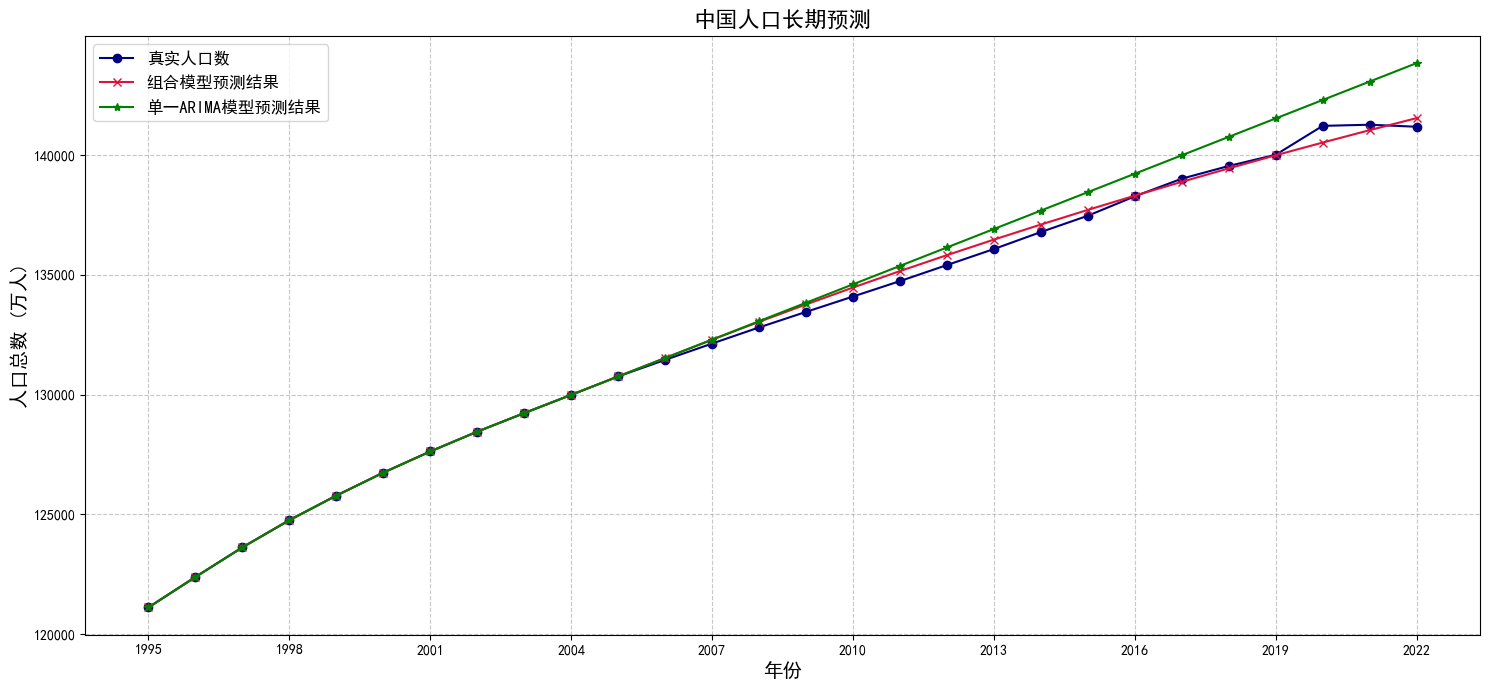

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
# 将提供的序列转换为数组并进行处理
# 序列1：实际值
Y_actual = np.array([
    121121, 122389, 123626, 124761, 125786, 126743, 127627, 128453, 129227, 129988,
    130756, 131448, 132129, 132802, 133450, 134091, 134735, 135404, 136072, 136782,
    137462, 138271, 139008, 139538, 140005, 141212, 141260, 141175
])

# 序列2：组合模型预测值
Y_predicted = np.array([
    121121, 122389, 123626, 124761, 125786, 126743, 127627, 128453, 129227, 129988,
    130756, 131527.751976, 132289.454506, 133034.553047, 133760.476130, 134466.401829,
    135152.351948, 135818.697747, 136465.994585, 137094.840867, 137705.876650,
    138299.719210, 138876.997346, 139438.303624, 139984.236417, 140515.355764,
    141032.227062, 141535.377704, 142025.341086
])

# 序列3：单一ARIMA模型预测值
Y_predicted2 = np.array([
    121121, 122389, 123626, 124761, 125786, 126743, 127627, 128453, 129227, 129988,
    130756, 131524.725758 ,132293.672665, 133062.686960 ,133831.721788, 134600.762873, 135369.805865, 136138.849438, 136907.893188,
    137676.936992, 138445.980813, 139215.024638, 139984.068465, 140753.112292, 141522.156120, 142291.199947, 143060.243775, 143829.287602,
    144598.331430,
])

# 对预测值进行处理，删除逗号，并转换为整数型
Y_predicted = np.array([float(str(val).replace(',', '')) for val in Y_predicted])

# 绘制折线图比较实际值和预测值
plt.figure(figsize=(15, 7))
actual_line, = plt.plot(range(1995, 2023), Y_actual, marker='o', label='真实人口数', color='navy')
predicted_line, = plt.plot(range(1995, 2023), Y_predicted[:28], marker='x', label='组合模型预测结果', color='crimson')
predicted_line2, = plt.plot(range(1995, 2023), Y_predicted2[:28], marker='*', label='单一ARIMA模型预测结果', color='g')

plt.title('中国人口长期预测', fontsize=16, fontweight='bold')
plt.xlabel('年份', fontsize=14)
plt.ylabel('人口总数 (万人)', fontsize=14)
plt.legend(handles=[actual_line, predicted_line, predicted_line2], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Ensure integer years on x-axis
plt.tight_layout()
plt.show()
